# *Outlier Detection Using Statistical Methods*, 

This chapter covers statistical methods for outlier and anomaly detection. These practical yet straightforward techniques are easy to interpret and implement. The chapter uses data from the **Numenta Anomaly Benchmark (NAB)** to evaluate different anomaly detection algorithms.

The recipes that you will encounter in this chapter are as follows:  
* Resampling time series data
* Detecting outliers using visualizations
* Detecting outliers using the Tukey method
* Detecting outliers using a z-score
* Detecting outliers using a modified z-score

# -- START --

* If you have the libraries installed check the versions 
* If the libraries are missing or you have an older version then either install or update the library

# Technical Requirements 
* Preparing for the recipes of this chapter

In [2]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


matplotlib -> 3.10.7
pandas -> 2.3.3   
scipy -> 1.16.2
statsmodels -> 0.14.5



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [4]:
plt.rcParams["figure.figsize"] = [12, 5]  

### Create DataFrames 

In [16]:
file = Path("data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

nyc_taxi.index.freq = '30min'

In [17]:
nyc_taxi.index.freq

<30 * Minutes>

In [18]:
nyc_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


<Axes: xlabel='timestamp'>

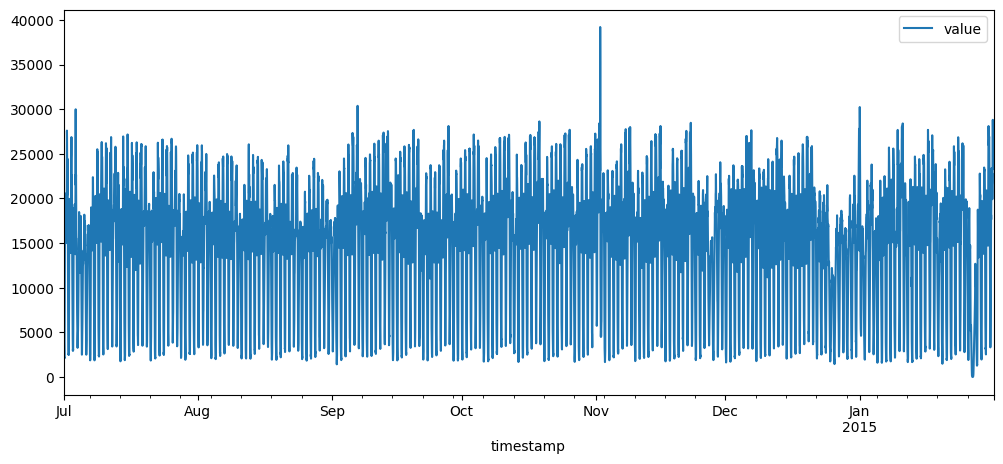

In [19]:
nyc_taxi.plot()

In [23]:
def plot_outliers(outliers, data, method='KNN', halignment='right', valignment='bottom', labels=False):
    """
    Plot time series data with highlighted outliers.
    
    Parameters
    ----------
    outliers : pandas.DataFrame or pandas.Series
        The DataFrame or Series containing the outlier data points.
    data : pandas.DataFrame or pandas.Series
        The complete time series data.
    method : str, default='KNN'
        The outlier detection method used, displayed in the plot title.
    halignment : str, default='right'
        Horizontal alignment for the date labels ('left', 'center', or 'right').
    valignment : str, default='bottom'
        Vertical alignment for the date labels ('top', 'center', or 'bottom').
    labels : bool, default=False
        If True, displays date labels for each outlier point.
        
    Returns
    -------
    None
        The function shows the plot but does not return any value.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
        
    data.plot(ax=ax, alpha=0.6)
    
    # Plot outliers
    if labels:
        outliers.plot(ax=ax, style='rx', markersize=8, legend=False)
        
        # Add text labels for each outlier
        for idx, value in outliers['value'].items():
            ax.text(idx, value, f'{idx.date()}', 
                   horizontalalignment=halignment, 
                   verticalalignment=valignment)
    else:
        outliers.plot(ax=ax, style='rx', legend=False)
    
    ax.set_title(f'NYC Taxi - {method}')
    ax.set_xlabel('date')
    ax.set_ylabel('# of passengers')
    ax.legend(['nyc taxi', 'outliers'])
    
    plt.tight_layout()
    plt.show()

### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

The New York Taxi dataset captures the number of NYC taxi passengers at a specific timestamp. The data contains known anomalies that are provided to evaluate the performance of our outlier detectors. The dataset contains 10,320 records between July 1, 2014, to May 31, 2015. The observations are captured in a 30-minute interval, which translates to freq = '30T'.

In [32]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [33]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

If you investigate these dates to gain more insight into their significance, you will find similar information to the following summary:
* Saturday, November 1, 2014, was before the New York Marathon, and the official marathon event was on Sunday, November 2, 2014.
* Thursday, November 27, 2014, was Thanksgiving Day.
* Thursday, December 25, 2014, was Christmas Day.
* Thursday, January 1, 2015, was New Year's Day.
* Tuesday, January 27, 2015, was the North American Blizzard where all vehicles were ordered off the street from January 26 to January 27, 2015.

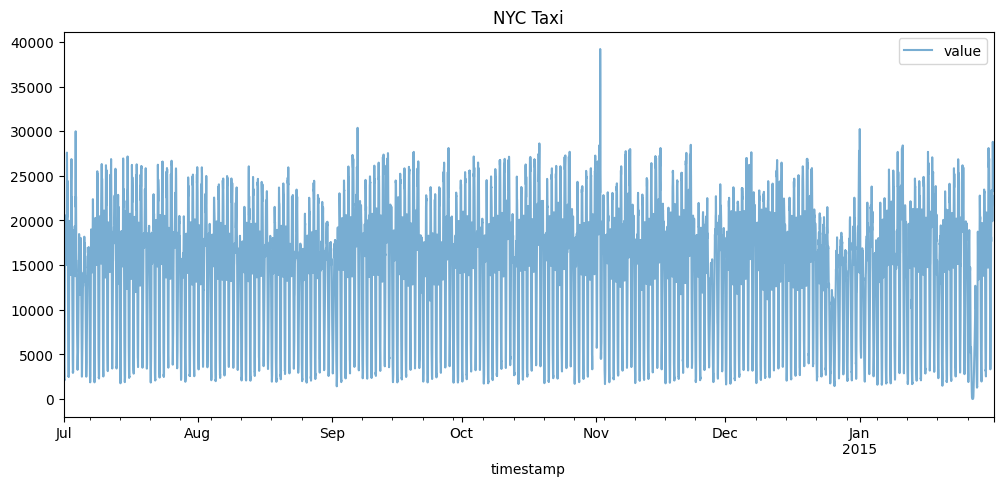

In [34]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.6);

In [35]:
nyc_taxi.index.freq = '30min'

In [36]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [37]:
tx = nyc_taxi.resample('D').mean()

In [38]:
known_outliers = tx.loc[nyc_dates]

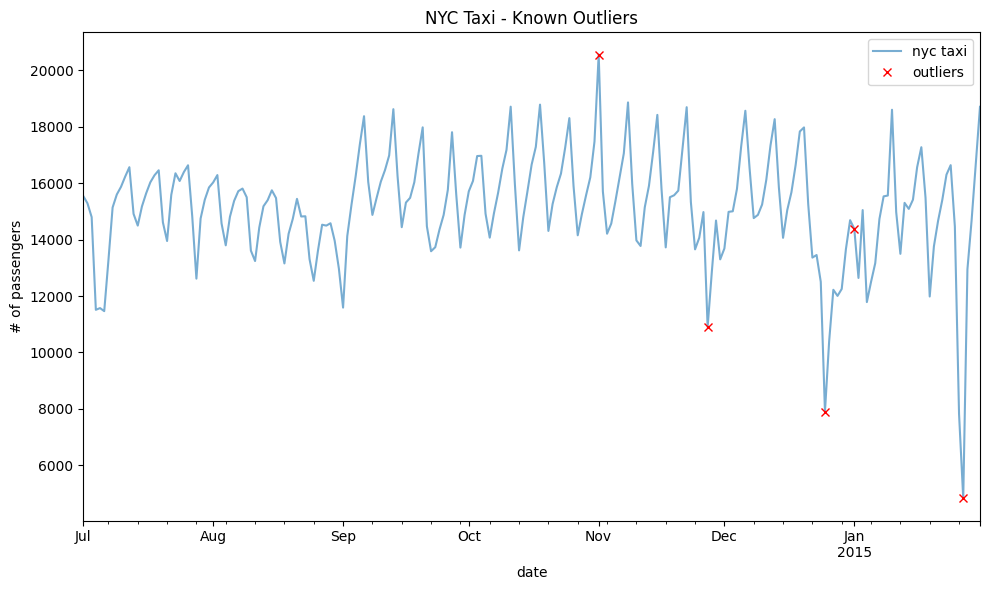

In [39]:
plot_outliers(known_outliers, tx, 'Known Outliers')

# Recipe 1. Resampling Time Series Data

Resampling transforms your time series data by changing its frequency, which can have significant implications for outlier detection. 

In this recipe, you will work with the `nyc_taxis` DataFrame created earlier in the Technical requirements section. The data captures the number of passengers in 30-minute intervals.

Resampling can be a valuable preprocessing step for outlier detection. By aggregating data to a lower frequency (downsampling), you can smooth out short-term noise and make it easier to identify unusual patterns or global outliers. You will first learn how downsampling works then move into upsampling.

## How to do it...

1. Let's start by examining the original DataFrame to understand our data:

In [ ]:
print(nyc_taxi.head())

Above we can see the first five rows of our time series data. Notice that the data has a timestamp index and a single `value` column representing the number of passengers. Let's check the frequency of the timestamps in our dataset:

In [ ]:
print(nyc_taxi.index.freq)

The output confirms that our data has a 30-minute frequency. Now let's perform our first downsampling operation by resampling the data to a daily frequency using the mean value:

In [ ]:
df_downsampled = nyc_taxi.resample('D').mean()
print(df_downsampled.head())

Resampling is done using the `DataFrame.resample()` function. For daily frequency, we use 'D' as the date offset rule, followed by `.mean()` as the method of aggregation to get daily averages.

Notice how the DatetimeIndex is now at a daily frequency, and the number of passengers now reflects the daily average. Let's check the frequency of the downsampled data:

In [ ]:
print(df_downsampled.index.freq)

The output confirms that our downsampled data now has a daily frequency. Let's check how many records we have after downsampling:

In [ ]:
df_downsampled.shape

We now have 215 records, significantly fewer than our original dataset. This reduction in data points is what makes downsampling valuable for outlier detection - it smooths out short-term noise and highlights longer-term patterns.

## 2. Using Different Downsampling Frequencies

Next, let's resample the data to a 3-day frequency. We'll use the offset string '3D' and apply the `.sum()` method instead for a cumulative view:

In [ ]:
df_downsampled = nyc_taxi.resample('3D').sum()
print(df_downsampled.head())

Now the values represent the sum of passengers over each 3-day period. Let's check how many records we have with this 3-day frequency:

In [ ]:
df_downsampled.shape

We now have 72 records, further reducing the data size. Let's verify the frequency:

In [ ]:
print(df_downsampled.index.freq)

The output confirms we're working with data at 3-day intervals.

## 3. Using Business Day Frequency

Now, let's change the frequency to three (3) business days instead. The default in pandas is Monday to Friday, which excludes weekends. We'll use '3B' as the DateOffset:

In [ ]:
df_downsampled = nyc_taxi.resample('3B').sum()
print(df_downsampled.head())

Notice the interesting output in how it skips 5 days from 2014-07-04 to 2014-07-09, and then again from 2014-07-09 to 2014-07-14. This is because of the Business Day rule, which specifies we have two days of the week as weekends.

Since the function is calendar-aware, it knows a weekend is coming after the first 3-day increment, so it adds a 2-day weekend to skip them, resulting in a 5-day jump. Starting from 2014-07-04, it moves to 2014-07-09, and from 2014-07-09 to 2014-07-14, and so on.

## 4. Upsampling Data

So far we've been downsampling (reducing frequency), but we can also upsample (increase frequency). Let's upsample our data from a 30-minute interval to a 15-minute frequency:

In [ ]:
df_upsampled = nyc_taxi.resample('15min').mean()
print(df_upsampled.head())

Notice that upsampling creates NaN rows for the new timestamps. Unlike downsampling, when upsampling, we need to give instructions on how to fill the NaN values.

You might be wondering why we used `.mean()` here. The simple answer is because it wouldn't matter whether we used `.sum()`, `.max()`, or `.min()`. This is because pandas `resample()` always requires an aggregation function, even if it's just a placeholder before imputation.

Let's explore different aggregation methods when upsampling:

In [ ]:
# Using .mean(), .sum(), .min(), or .max()
df_upsampled = nyc_taxi.resample('15min').sum()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').mean()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').min()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').max()
print(df_upsampled.head())


As you can see, regardless of which aggregation method we use (sum, mean, min, max), the original values remain at their original timestamps, and NaN values are inserted for the new timestamps created by upsampling.

To handle these NaN values, we need to use imputation techniques. Let's try using forward fill (ffill) to propagate the last valid observation forward:

In [ ]:
# nyc_taxi.resample('15T').fillna('ffill').head()
df_upsampled = nyc_taxi.resample('15min').ffill()
print(df_upsampled.head())


With forward filling, each NaN value is replaced with the last valid value that came before it. In this case, each 30-minute value gets carried forward to fill the new 15-minute timestamp that follows it.

Let's look at another way to perform forward filling in a single step:

In [ ]:
print(nyc_taxi.resample('15min').ffill().head())

Here we achieve the same result as before, but with a more compact syntax. Now let's view the entire upsampled dataset:

In [ ]:
nyc_taxi.resample('15min').ffill()

## How it works...

The `DataFrame.resample()` method allows you to group rows in a specified time frame, for example, by day, week, month, year, or any DateTime attribute. The way `.resample()` works is by grouping the data using the DatetimeIndex and the frequency provided, hence, this method is specific to time series DataFrames.

The `.resample()` function works in a very similar manner to the `.groupby()` function; the difference is that `.resample()` is specific to time series data and groups at the DatetimeIndex. When you call the `.resample()` on a DataFrame, it returns a Resampler object, which is similar to the GroupBy object.

The resampling process follows these steps:
- The data is grouped based on the specified frequency
- For downsampling, an aggregation function (like `.mean()`, `.sum()`, `.min()`, or `.max()`) must be applied to combine multiple values into one
- For upsampling, new rows are created with NaN values, which can then be filled using methods like `.ffill()`, `.bfill()`, or custom interpolation

The offset strings used in resampling follow pandas' DateOffset aliases. Some common ones include:
- 'D': Calendar day
- 'B': Business day
- 'W': Weekly
- 'ME': Month end
- 'MS': Month start
- 'QE': Quarter end
- 'QS': Quarter start
- 'YE': Year end
- 'YS': Year start
- 'h': Hourly
- 'min': Minute
- 'S': Second

You can also specify multiples of these frequencies, as demonstrated with '3D' for every three days or '15min' for every 15 minutes.

For outlier detection purposes, downsampling to daily frequency offers a strategic advantage. While downsampling does smooth out the data by combining multiple observations, it doesn't necessarily eliminate evidence of outliers. In fact, when using the mean as your aggregation method, extreme values continue to influence the daily average.

## There's more...

You can supply more than one aggregation at once when downsampling using the `.agg()` function. For example:

In [43]:
print(nyc_taxi.resample('MS').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

                   value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889


In [42]:
print(nyc_taxi.resample('ME').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

                   value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889


In [ ]:
print(nyc_taxi.resample('MS').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

In [45]:
result = nyc_taxi.resample('ME').agg(['mean', 
                                      'min', 
                                      'max', 
                                      'median', 
                                      'sum'])
# Rename the columns
result.columns = ['Mean', 'Minimum', 'max', 'median', 'sum'] 
print(result)

                    Mean  Minimum    max   median       sum
timestamp                                                  
2014-07-31  14994.084677     1769  29985  16625.5  22311198
2014-08-31  14580.438844     1841  26062  16184.0  21695693
2014-09-30  15623.374306     1431  30373  17244.5  22497659
2014-10-31  16086.851478     1691  28626  17767.5  23937235
2014-11-30  15492.125000     1683  39197  17287.0  22308660
2014-12-31  14813.428763     1459  27804  16587.0  22042382
2015-01-31  14399.790995        8  30236  16061.0  21426889


Using the `.agg()` function, we can apply multiple aggregation methods at once, creating a multi-column DataFrame. Notice that the resulting DataFrame has a hierarchical column index (MultiIndex). We can rename the columns to have simpler names as shown in the example above.

This multiple aggregation approach can be particularly valuable for outlier detection as it allows you to examine different statistical properties simultaneously. For instance, looking at the January 2015 data in our example, we can see a minimum value that stands out dramatically compared to other months' minimums, which corresponds to the North American Blizzard mentioned earlier.

Note that the string 'M' is being deprecated and will be replaced by 'ME' (Month End). You can also use 'MS' for Month Start, which will produce timestamps like 2014-07-01 instead (the beginning of each month).

Overall, resampling in pandas is very convenient and straightforward. This is a handy tool when you want to change the frequency of your time series data to prepare it for outlier detection or other analyses.

# Recipe 2. Detecting Outliers using Visualization

In this recipe, you will explore different visualization techniques available in the seaborn library to detect outliers in your time series data. Visualizations provide an intuitive way to identify potential anomalies before applying more sophisticated statistical methods.

You will learn how to use various plots including:
- Histograms with `histplot()` and `displot()`
- Box plots with `boxplot()`
- Letter-value plots with `boxenplot()`
- Violin plots with `violinplot()`

Each visualization technique presents the data distribution differently, helping you identify patterns and potential outliers from multiple perspectives. By the end of this recipe, you'll understand the strengths and limitations of each approach for outlier detection.

## How to do it...

Let's start by importing the seaborn library and examining our data:

In [46]:
import seaborn as sns
sns.__version__

'0.13.2'

First, we need to import seaborn, which provides enhanced visualization capabilities built on top of matplotlib. Seaborn offers specialized plots that are particularly useful for detecting outliers.

In [47]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


Next, let's recall our known outliers from the NYC taxi dataset. These are dates we previously identified as containing anomalies, which will serve as our ground truth for evaluating different visualization methods.

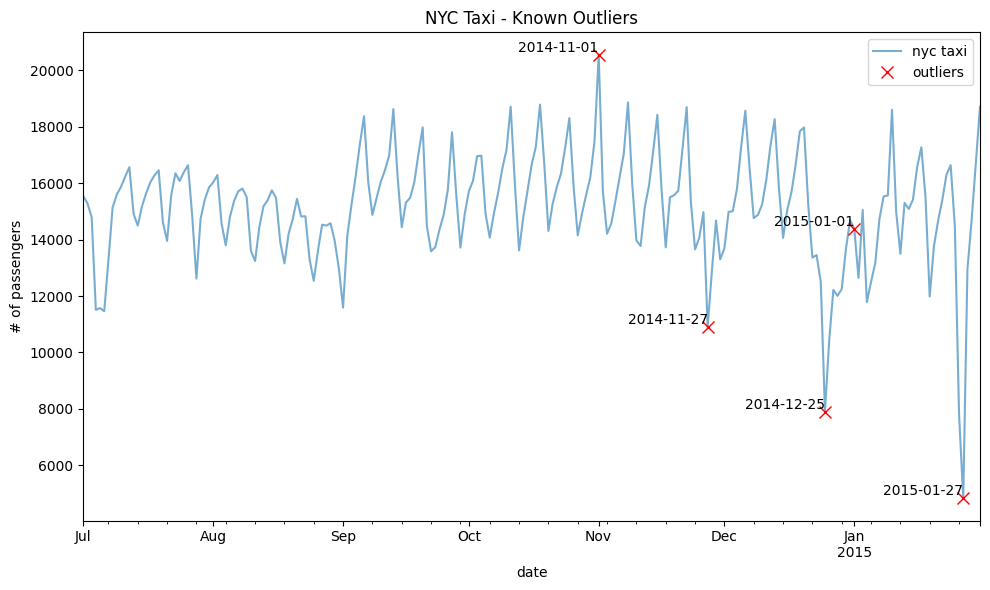

In [48]:
tx = nyc_taxi.resample('D').mean()
known_outliers= tx.loc[nyc_dates]
plot_outliers(known_outliers, tx, 'Known Outliers', labels=True)

For this recipe, we'll use the daily resampled data (`tx`) to find which days have outlier observations rather than looking at specific 30-minute intervals. Even though resampling smooths the data, the mean aggregation still preserves the influence of extreme values, allowing us to detect daily anomalies.

Let's visualize our known outliers on the time series plot to see their positions relative to the overall data:

## 1. Histogram

Histograms are one of the most basic but effective tools for visualizing data distribution. They group data into bins and show the frequency of observations in each bin, helping us identify:
- The overall shape of the distribution
- Potential clusters or modes in the data
- Values that fall far from the central tendency

Let's create a histogram of our daily passenger counts:

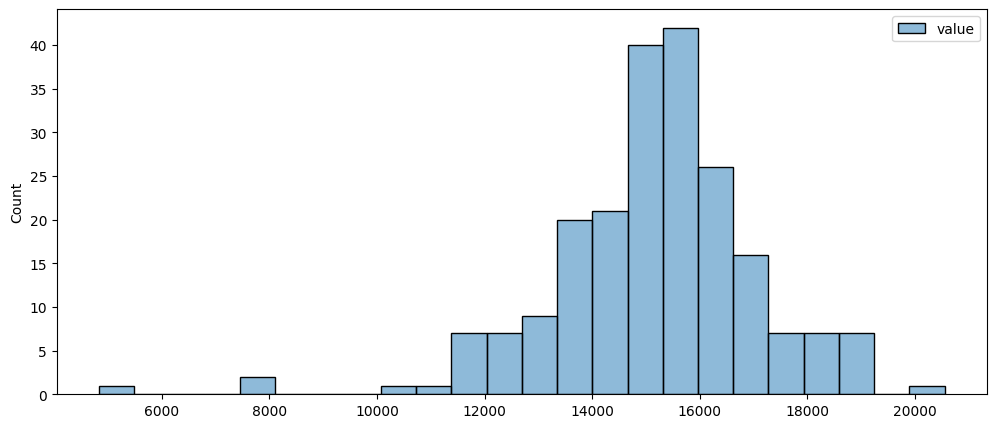

In [49]:
sns.histplot(tx);

In this histogram, we can observe the distribution of daily mean passenger counts. The values appearing at the extreme left and right of the distribution are potential outliers. 

The center of the histogram is around 15,000 daily average passengers. The observations with very low passenger counts (below 8,000) appear to be more extreme compared to the rest and may be actual outliers. The values at the high end (close to 20,000) might also be outliers, but they're less distinct from the main distribution.

Let's try another way to visualize the histogram using seaborn's `displot()` function:

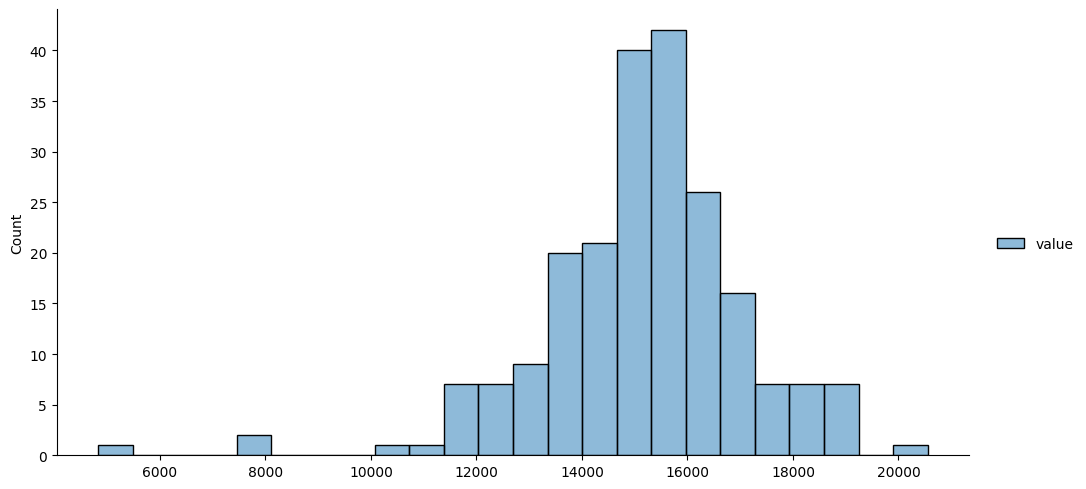

In [50]:
sns.displot(tx, kind='hist', height=5, aspect=2);

The `displot()` function provides similar information to `histplot()` but with more customization options. Here we've adjusted the height and aspect ratio for better visualization. 

While histograms are useful for understanding the overall distribution, they don't provide a clear threshold for what constitutes an outlier. For this, we'll explore box plots next.

## 2. Box Plot

Box plots are particularly valuable for outlier detection because they establish statistical boundaries (the whiskers) based on the interquartile range (IQR). Points beyond these boundaries are explicitly highlighted as potential outliers.

A box plot displays:
- The median (middle line in the box)
- The interquartile range or IQR (Q3 - Q1, represented by the box)
- The whiskers (typically extending to 1.5 * IQR beyond Q1 and Q3)
- Individual points beyond the whiskers (potential outliers)

Let's create a horizontal box plot for our data:

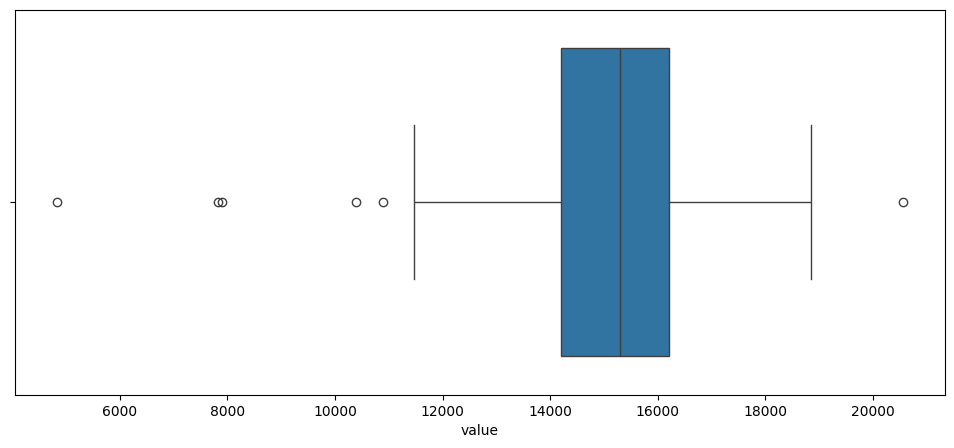

In [55]:
sns.boxplot(tx['value'], orient='h', whis=1.5);

In this box plot, we can see potential outliers as individual points outside the whiskers. These represent values that are more than 1.5 times the IQR away from the first quartile (Q1) or third quartile (Q3).

The default `whis` parameter in seaborn's `boxplot()` function is 1.5, which corresponds to Tukey's definition of outliers. Let's explicitly set this parameter to see if the output changes:

In [ ]:
sns.boxplot(tx['value'], orient='h', whis=1.5);

The result is identical to the previous box plot since we used the default value of `whis=1.5`. You can adjust this parameter to change the width of the whiskers:
- Smaller values of `whis` will identify more observations as outliers
- Larger values will be more conservative in labeling points as outliers

The width of the box represents the IQR (Q3 - Q1). The lower fence is calculated as Q1 - (1.5 × IQR), and the upper fence as Q3 + (1.5 × IQR). Any observation below the lower fence or above the upper fence is considered a potential outlier.

Next, let's explore a variation of the box plot called the boxen plot (or letter-value plot).

## 3. Boxen Plot (Letter Value Plot)

The boxen plot (also known as a letter-value plot) is an enhancement to regular box plots, especially useful for larger datasets. It was introduced in the paper by Heike Hofmann, Hadley Wickham & Karen Kafadar (2017), "Letter-Value Plots: Boxplots for Large Data."

Boxen plots extend beyond the quartiles shown in traditional box plots, providing more detailed information about the distribution's tails where outliers typically reside. This makes them particularly effective for:
- Differentiating between outliers in larger datasets
- Showing more granular distribution information
- Detecting subtle anomalies that might be missed in traditional box plots

Let's create a boxen plot:

In [ ]:
sns.boxenplot(tx['value'],orient='h');

The boxen plot shows multiple nested boxes beyond the quartiles displayed in a traditional box plot. Each box represents a different letter value, providing more detailed distribution information.

To understand the exact values of the quartiles, we can examine the descriptive statistics:

In [ ]:
# changing depth with numeric value
sns.boxenplot(tx['value'], k_depth=1, orient='h') 

In [ ]:
print(tx.describe())

From these statistics, we can see:
- The 25th percentile (Q1) is at 14,205 daily average passengers
- The median (Q2) is at 15,300 daily average passengers
- The 75th percentile (Q3) is at 16,209 daily average passengers

We can also explore different depth options in the boxen plot. The `k_depth` parameter controls how many boxes are shown and can be set as a numeric value or using different methods:

In [ ]:
# changing depth with numeric value
sns.boxenplot(tx['value'], k_depth=1, orient='h');

Here, we set `k_depth=1` to show just the central box (similar to a traditional box plot). Let's explore different methods for determining the depth:

In [ ]:
# exploring different methods 
for k in ["tukey", "proportion", "trustworthy", "full"]:
    plt.figure(figsize=(12, 3)) 
    sns.boxenplot(tx['value'], k_depth=k, orient='h')
    plt.title(f'k_depth={k}')
    plt.show()


The different methods produce varying numbers of boxes in the visualization:

1. **tukey**: The default method, which uses letter values until the amount of data needed for a level exceeds the total remaining data (produces 4 boxes in our example)
2. **proportion**: Creates boxes with exponentially decreasing proportions of data
3. **trustworthy**: Uses the smallest set of letter values needed for "trustworthy" estimation
4. **full**: Shows letter values for the full range of the data

These different depth methods allow you to adjust the level of detail in the visualization based on your dataset's characteristics and the specific outlier detection goals.

## Violin Plot

Violin plots combine aspects of box plots with density plots, making them powerful tools for visualizing the distribution of data and identifying outliers. They display:

1. A central box plot showing the median, interquartile range, and whiskers
2. A kernel density estimation that shows the full distribution shape
3. The width of the "violin" at any given point represents the density of data at that value

This visualization is particularly useful for:
- Revealing multimodality (multiple peaks) in your data that might indicate different populations or anomaly clusters
- Identifying asymmetry in distributions
- Showing the full distribution while still highlighting outliers

In [ ]:
sns.violinplot(tx['value'], inner='quartile', orient='h');

In this example:

- We create a horizontal violin plot of our taxi passenger count data
- The `inner='quartile'` parameter adds box plot quartile lines inside the violin
- The central white dot represents the median
- The thick black bar in the center represents the interquartile range (IQR)
- The thin black lines extending from the box represent the whiskers (typically 1.5 × IQR)
- Points beyond the whiskers are potential outliers
- The width of the violin shows the density distribution

Notice how the violin plot clearly shows the asymmetry in our data distribution and highlights the potential outliers at higher passenger count values.

## There is more

Beyond the basic visualization techniques covered above, there are several additional approaches that can be useful for outlier detection:

1. **Kernel Density Estimation (KDE)** plots - These smooth density estimations can help identify areas where data points are sparse, potentially indicating outliers
2. **Lag plots** - Particularly useful for time series data to detect outliers that disrupt temporal patterns
3. **Specialized statistical tests** - Such as Grubbs' test or the Generalized ESD test for formal outlier detection

Let's explore some of these additional methods:

In [ ]:
sns.displot(tx['value'], kind='hist', height=5, aspect=2, kde=True);

### KDE with Histograms

This visualization combines a histogram with a kernel density estimation (KDE) curve overlay. The KDE provides a smooth probability density function of the data, which can help in identifying:

- Unusual gaps in the distribution
- Areas of unusually low density that may contain outliers
- Multimodality that might indicate different data regimes or anomalies

The `displot()` function from seaborn provides a figure-level interface for drawing distribution plots, allowing us to set the figure dimensions with `height` and `aspect` parameters.

In [ ]:
sns.histplot(tx['value'], kde=True);

An alternative approach is to use the `histplot()` function, which is similar but offers a more direct interface specifically for histograms. The KDE overlay helps to better visualize the continuous probability distribution of the data, making it easier to identify where data points might be considered unusual or outliers based on their probability density.

### Lag Plot

Lag plots are particularly useful for time series data as they help visualize:

1. **Autocorrelation** - How strongly the current value relates to previous values
2. **Temporal patterns** - Cyclic or seasonal patterns in the data
3. **Outliers** - Points that deviate significantly from the established pattern

A lag plot shows each data point plotted against its previous value (by default with lag=1). Points that fall far from the main cluster in a lag plot often represent anomalous changes in the time series.

In [ ]:
from pandas.plotting import lag_plot

In [ ]:
# default lag=1
lag_plot(tx['value'], lag=1);

In this lag plot:

- Each point represents a data point (y-axis) and its previous value (x-axis)
- The pattern and shape of the scatter points reveal the time series structure
- Strong autocorrelation appears as points clustering along a diagonal line
- Points far from the main cluster may represent outliers or anomalous shifts in the time series
- The default `lag=1` parameter means we're comparing each value with the immediately preceding value

For seasonal data, you might want to experiment with different lag values (e.g., lag=7 for weekly patterns or lag=24 for daily patterns in hourly data) to better reveal anomalies.

Creating a Lag Plot using `seaborn.scatterplot`

In [ ]:
y = tx[1:].values.reshape(-1)
x = tx[:-1].values.reshape(-1)
sns.scatterplot(x=x, y=y);

Here we've created our own lag plot using `seaborn.scatterplot()` by:

1. Creating a y-array with all values except the first one
2. Creating an x-array with all values except the last one
3. Plotting x versus y, which represents each value against its previous value

This manual approach gives you more flexibility to customize the visualization or apply different transformations to the lagged data. It's particularly useful when you want to:

- Add color coding based on specific criteria
- Apply different styling to highlight potential outliers
- Incorporate additional dimensions of information

In both lag plot approaches, points that are isolated from the main cluster pattern may indicate anomalous changes in your time series that warrant further investigation.

## How it Works - Visualization-Based Outlier Detection

Visualization-based outlier detection leverages our visual system's ability to identify patterns and deviations. The effectiveness of these methods stems from several principles:

1. **Distribution Shape Analysis**: Histograms, KDE plots, and violin plots help visualize the overall distribution shape, making it easy to spot values that fall in low-density regions.

2. **Statistical Boundaries**: Box plots and boxen plots use statistical measures like quartiles and their derivatives (IQR) to establish boundaries for what constitutes "normal" data, with points beyond these boundaries highlighted as potential outliers.

3. **Temporal Pattern Recognition**: For time series data, lag plots help identify points that break established patterns of autocorrelation, which often indicate anomalies.

4. **Multi-dimensional Representations**: More advanced techniques like violin plots combine multiple statistical perspectives (central tendency, spread, distribution shape) to provide a more comprehensive view for outlier detection.

The key advantage of visualization-based methods is their ability to provide immediate insights without requiring complex algorithms. However, they do have limitations:

- They become less effective with very high-dimensional data
- They rely on human interpretation, which can be subjective
- They work best as an exploratory first step rather than as definitive outlier classification

In practice, these visualization techniques are most powerful when used in combination and as part of a broader outlier detection strategy that may include more algorithmic approaches.

# Recipe 3. Detecting Outliers using Tukey's Method

Tukey's method (also known as the IQR method or boxplot method) is a robust statistical approach for identifying outliers. Unlike methods that rely on mean and standard deviation (which are sensitive to outliers themselves), Tukey's method uses quartiles, which are more resistant to the influence of extreme values.

This recipe demonstrates how to:
1. Calculate quartiles and the interquartile range (IQR)
2. Define boundaries for potential outliers using the IQR
3. Identify and filter outliers based on these boundaries
4. Visualize the results to understand the impact of outlier removal

## Define the `iqr_outliers` function

Before applying Tukey's method, we'll first look at various ways to compute percentiles and quartiles in Python. This helps us understand the underlying statistical concepts before implementing the outlier detection algorithm.

First, we prepare our data by resampling to daily values and examine its statistical distribution using the `describe()` method with custom percentiles. This helps us understand the spread and central tendency of our data before looking for outliers.

In [57]:
tx.describe()

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
25%,14205.197917
50%,15299.937500
75%,16209.427083
max,20553.500000


In [58]:
tx = nyc_taxi.resample('D').mean()
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


Here we're using NumPy's `percentile()` function as an alternative way to calculate the same percentiles. This function computes the q-th percentile of the data along the specified axis. The percentiles are given as integers (0-100) rather than decimals (0-1).

In [59]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

NumPy also provides the `quantile()` function, which is similar to `percentile()` but works with quantiles (decimals from 0-1) instead of percentiles (0-100). The results are identical to our previous calculation, just using a different scale. For Tukey's method, we'll be focusing on the quantiles at 0.25 (Q1) and 0.75 (Q3).

In [60]:
quantiles = [0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 1]
np.quantile(tx, quantiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

## Implementing Tukey's Method

Now we'll implement Tukey's method for outlier detection. This approach is based on the interquartile range (IQR), which is the range between the first quartile (Q1) and third quartile (Q3).

Tukey's method works by:
1. Calculating Q1 (25th percentile) and Q3 (75th percentile)
2. Computing the IQR as Q3 - Q1
3. Defining "fences" (boundaries) at Q1 - k×IQR and Q3 + k×IQR
4. Classifying any points beyond these fences as potential outliers

The parameter `k` determines how sensitive the detection is. Traditionally:
- k = 1.5 identifies "mild" outliers (commonly used)
- k = 3.0 identifies "extreme" outliers

This method is robust because it's based on quartiles, which are less influenced by extreme values than mean and standard deviation.

In [61]:
def iqr_outliers(data, k):
    """
    Detect outliers using Tukey's method with customizable fence multiplier.
    
    Parameters:
    data (DataFrame): Time series data with a 'value' column
    k (float): The fence multiplier to use (typically 1.5)
    
    Returns:
    DataFrame: Filtered data containing only outlier points
    """
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (k * IQR)
    upper_fence = q3 + (k * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

Now let's apply our `iqr_outliers` function to our daily taxi passenger data with the standard k=1.5 value and see what potential outliers it identifies.

In [65]:
outliers = iqr_outliers(tx, 1.5)
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


Next, let's visualize these outliers on our time series using the `plot_outliers` function. This will help us see where these potential anomalies occur in relation to the overall passenger count pattern. The `labels=True` parameter adds date labels to our outliers to make them easier to identify.

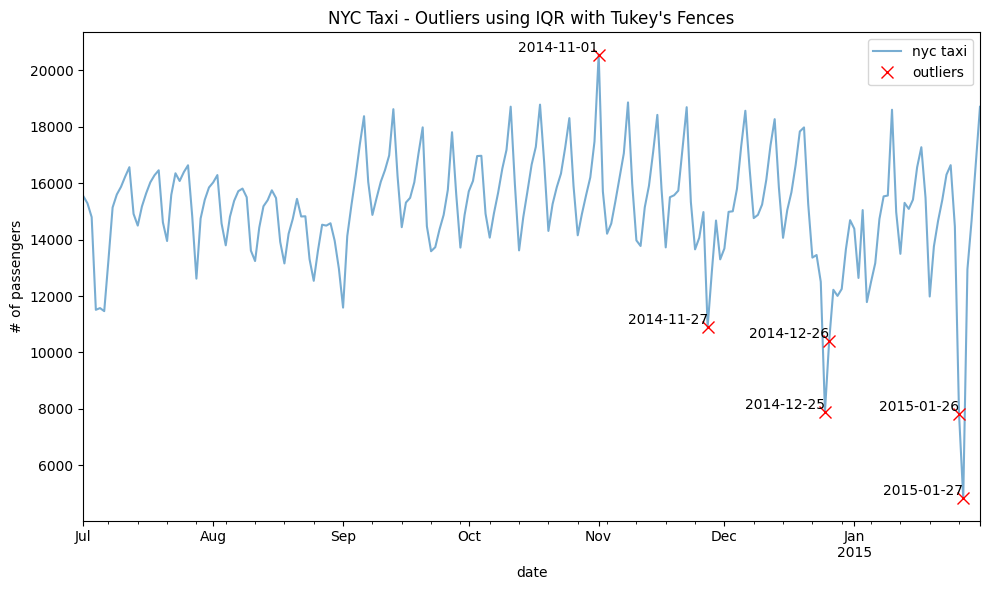

In [66]:
plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences", labels=True)

Let's look at our known outliers from the dataset for comparison. This will help us evaluate how well Tukey's method performed in identifying the actual anomalies in our dataset.

In [67]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


Now let's visualize the known outliers on our time series. This will allow us to visually compare how well our Tukey's method was able to identify these known anomalies.

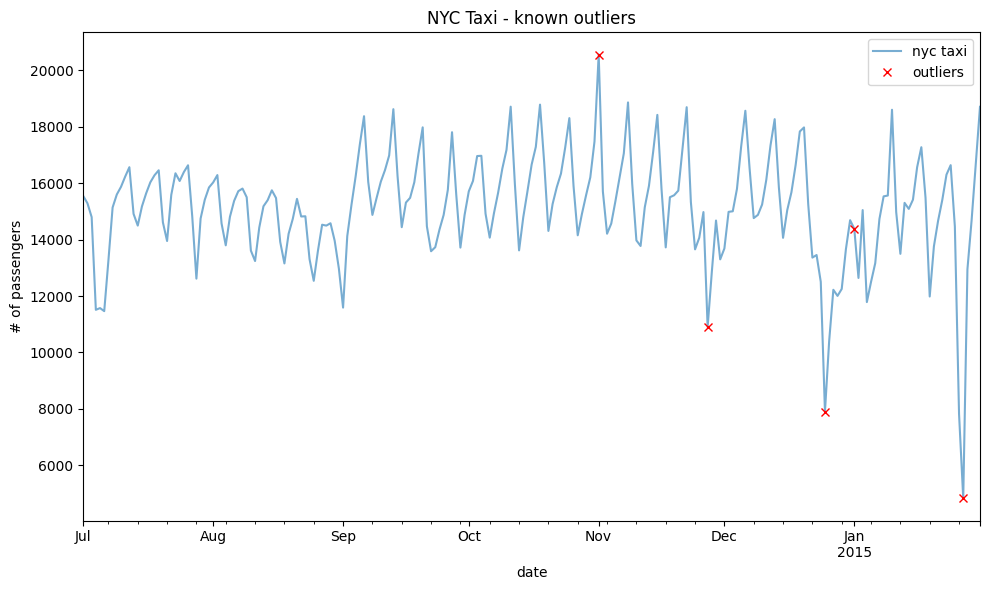

In [68]:
plot_outliers(known_outliers, tx, "known outliers")

## There is more

The standard Tukey's method uses k=1.5, but this multiplier is somewhat arbitrary and can be adjusted based on your data characteristics and how sensitive you want your outlier detection to be. Let's experiment with different values of k to see how it affects the number of outliers detected.

In [69]:
for k in [1.3, 1.5, 2.0, 2.5,  3.0]:
    print(f'using k={k}')
    print(iqr_outliers(tx, k))
    print('-'*25)

using k=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
-------------------------
using k=3.0
                  value
timestamp        

In this loop, we're applying our `iqr_outliers` function with different k values to demonstrate how this parameter affects sensitivity:

- **k=1.3**: A more sensitive setting that will detect more outliers but may include some false positives
- **k=1.5**: The standard setting commonly used in statistical analysis
- **k=2.0**: A more conservative setting that detects fewer outliers
- **k=2.5** and **k=3.0**: Very conservative settings that detect only the most extreme outliers

By comparing the results, we can tune the sensitivity of our outlier detection based on domain knowledge and specific requirements.

# Recipe 4. Detecting Outliers using Z-Scores

Another common method for detecting outliers is using Z-scores, which measures how many standard deviations a data point is from the mean. This approach is more suitable when your data follows a normal distribution.

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [100]:
def zscore(df, threshold=3):
    """
    Detect outliers using z-score method with customizable threshold.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    threshold (float): The threshold in standard deviations (typically 2-3)
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with z-scores)
    """
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -threshold) | (data['zscore'] >= threshold)]
    
    return outliers, data

In [101]:
tx = nyc_taxi.resample('D').mean()
threshold = 2.5
outliers, transformed = zscore(tx, threshold)

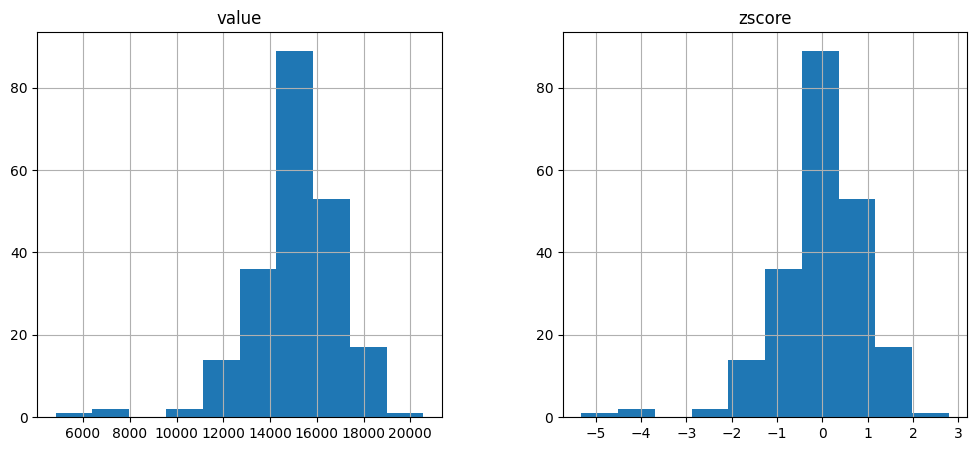

In [102]:
transformed.hist();

In [103]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [104]:
print(outliers['value'])

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


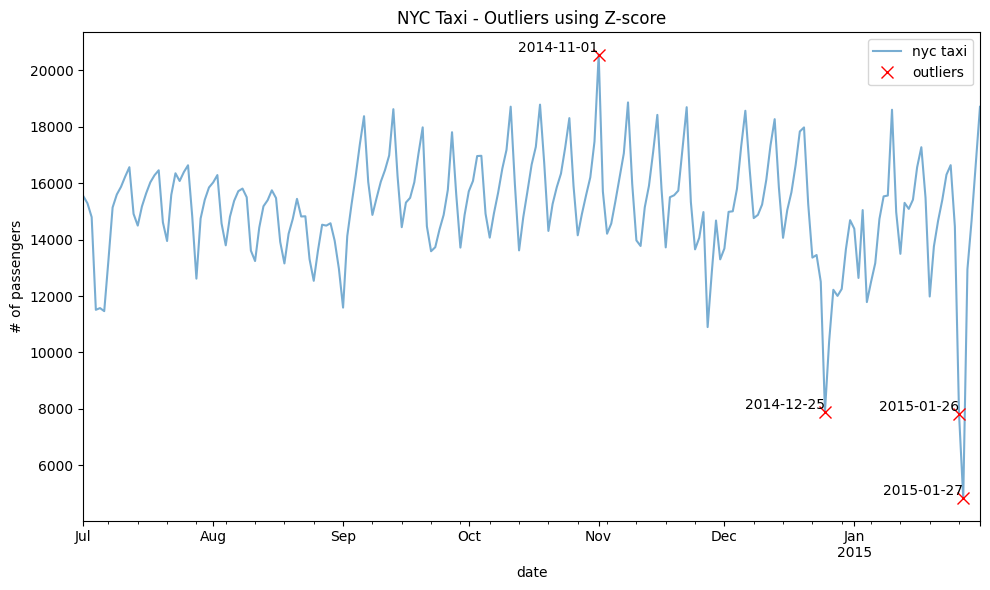

In [105]:
plot_outliers(outliers[['value']], tx, 'Outliers using Z-score', labels=True)

## Creating a Z-Score Visualization Function

To better understand how the z-score method identifies outliers, let's create a specialized visualization function. This function will:

1. Plot all data points based on their z-score values
2. Add horizontal threshold lines at the specified standard deviation boundaries
3. Highlight points that exceed the threshold (outliers) with a different color

This visualization makes it easier to interpret which data points are considered anomalous and how far they deviate from the normal range.

In [106]:
def plot_zscore(data_series, d=3):
    """
    Plot the standardized z-scores with threshold lines using Series index for x-axis.
    
    Parameters:
    - data_series: Series containing z-scores with datetime index
    - d: Threshold in standard deviations (default: 3)
    """
    
    plt.plot(data_series.index, data_series.values, 'k^', markersize=4)
    
    plt.axhline(y=d, color='r', linestyle='--', label=f'+{d} SD')
    plt.axhline(y=-d, color='r', linestyle='--', label=f'-{d} SD')
    
    # Highlight outliers
    outliers = data_series[abs(data_series) > d]
    if not outliers.empty:
        plt.plot(outliers.index, outliers.values, 'ro', markersize=8, label='Outliers')
    
    plt.ylabel('Z-score')
    plt.title('Standardized Taxi Passenger Data with Outlier Thresholds')
    plt.legend()
    
    # Format x-axis for dates
    plt.gcf().autofmt_xdate()
    plt.tight_layout()


Let's apply our `plot_zscore` function using the same threshold value of 2.5 that we used for our outlier detection. This visualization will display:

1. All data points as black triangles showing their z-score values
2. Horizontal red dashed lines at +/- 2.5 standard deviations marking our threshold boundaries
3. Red circles highlighting the points identified as outliers (those beyond our thresholds)

This visualization makes it easy to see exactly which points are considered anomalous according to our z-score criterion.

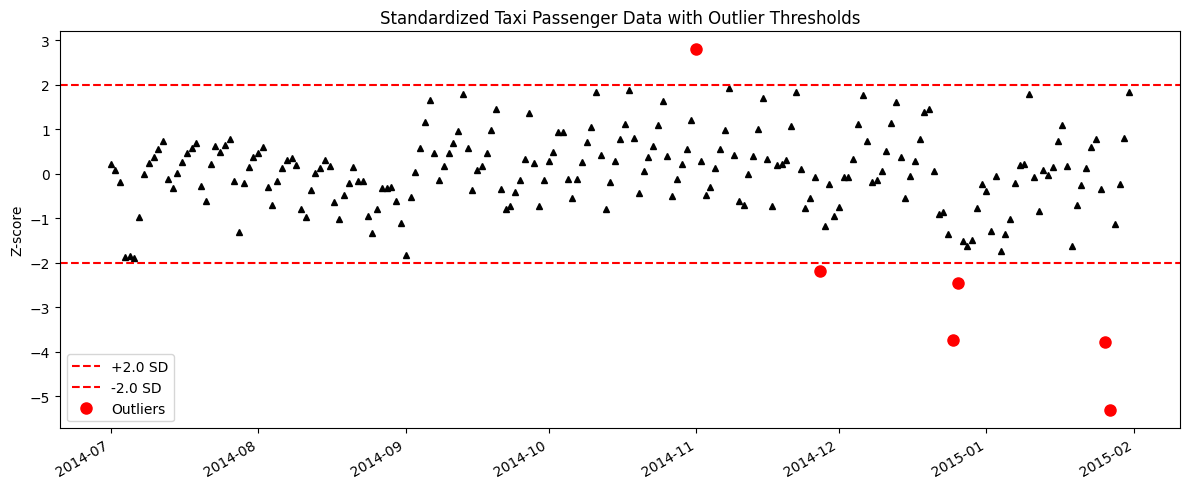

In [107]:
plot_zscore(transformed['zscore'], d=2.0)


In [83]:
outliers

,value,zscore
timestamp,,
2014-11-01,20553.500000,2.795476
2014-12-25,7902.125000,-3.734633
2015-01-26,7818.979167,-3.777549
2015-01-27,4834.541667,-5.317991


## There's More

Since the z-score method assumes that the data follows a normal distribution, it's important to test this assumption before applying the method. If the data is not normally distributed, the z-score results may be misleading.

Let's create a function that uses the Kolmogorov-Smirnov test to check if our data follows a normal distribution:

In [ ]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    """
    Test if data follows a normal distribution using Kolmogorov-Smirnov test.
    
    Parameters:
    df (Series or array-like): Data to test for normality
    
    Returns:
    None: Prints whether to reject or fail to reject the null hypothesis
    """
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

Now let's run the normality test on our taxi data to see if the z-score method is appropriate for this dataset:

In [86]:
test_normal(tx)

Reject null hypothesis. Data is not normal


## Conclusion on Z-Score Method

Our normality test indicates that our taxi data is **not normally distributed**. This is important because:

1. The z-score method assumes data follows a normal distribution
2. When applied to non-normal data, the standard z-score thresholds may not be appropriate
3. This could lead to either missing true outliers or flagging too many false positives

This limitation brings us to our next recipe: the Modified Z-Score method, which is more robust to non-normal distributions and less influenced by extreme values.

# Recipe 5. Modified Z-Score
* Understand the difference between Z-Score and Modified Z-Score
* When to use Modified Z-Score (and the assumptions behind Z-score)
* Scipy's Percent Point Function (PPF)

In [90]:
import scipy.stats as stats
stats.norm.ppf(0.75)

np.float64(0.6744897501960817)

## Understanding the Percent Point Function

Before implementing the modified Z-score, let's understand the `ppf()` function from SciPy's stats module. The Percent Point Function (PPF) is the inverse of the Cumulative Distribution Function (CDF). 

For a standard normal distribution, `stats.norm.ppf(0.75)` returns the value below which 75% of the observations fall - which is approximately 0.6745. This constant will be used in our modified Z-score calculation to make it consistent with the standard normal distribution.

## Implementing Modified Z-Score Method

Next, we'll implement the modified Z-score method, which addresses the limitations of the standard Z-score approach by:

1. Using the **median** instead of the mean as a measure of central tendency
2. Using the **Median Absolute Deviation (MAD)** instead of standard deviation as a measure of dispersion

This makes the method more robust to outliers and non-normal distributions because median and MAD are less influenced by extreme values compared to mean and standard deviation.

The formula for the modified Z-score is:

$$M_i = \frac{0.6745 \times (x_i - \tilde{x})}{MAD}$$

Where:
- $M_i$ is the modified Z-score
- $x_i$ is the data point
- $\tilde{x}$ is the median of the data
- $MAD$ is the median absolute deviation
- $0.6745$ is the constant that makes the modified Z-score comparable to the standard Z-score for normal distributions

In [109]:
import scipy.stats as stats
def modified_zscore(df, threshold=3):
    """
    Detect outliers using a modified z-score method with customizable threshold.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    threshold (float): The threshold in standard deviations (typically 2-3)
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with m_zscores)
    """
    data = df.copy()
    
    # Calculate median and MAD
    median = data['value'].median()
    MAD = np.median(np.abs(data['value'] - median))

    # Calculate modified z-score
    s = stats.norm.ppf(0.75)
    data['m_zscore'] = s * (data['value'] - median) / MAD
    # Identify outliers
    outliers = data[(data['m_zscore'] > threshold) | (data['m_zscore'] < -threshold)]
    
    return outliers, data

## Applying the Modified Z-Score Method

Now let's apply our `modified_zscore()` function to the daily taxi passenger count data with a threshold of 3. This will:

1. Resample our data to daily averages
2. Calculate modified Z-scores for each data point
3. Identify outliers that exceed our specified threshold

The threshold value of 3 means we'll consider any point with a modified Z-score greater than 3 or less than -3 as an outlier.

In [110]:
tx = nyc_taxi.resample('D').mean()
threshold =  3
outliers, transformed = modified_zscore(tx, threshold)

### Checking Detection Results

Let's first check how many outliers were identified by our modified Z-score approach:

In [111]:
outliers.shape

(6, 2)

### Visualizing Distributions

To better understand how the modified Z-score transformation affects our data, let's create histograms of both the original values and the modified Z-scores:

These histograms help us compare the distribution of the original data (which is likely non-normal) with the distribution of the modified Z-scores. Note that unlike standard Z-scores, which would transform a normal distribution into another normal distribution, the modified Z-score preserves the shape of the original distribution - it simply rescales it using robust statistics.

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'm_zscore'}>]], dtype=object)

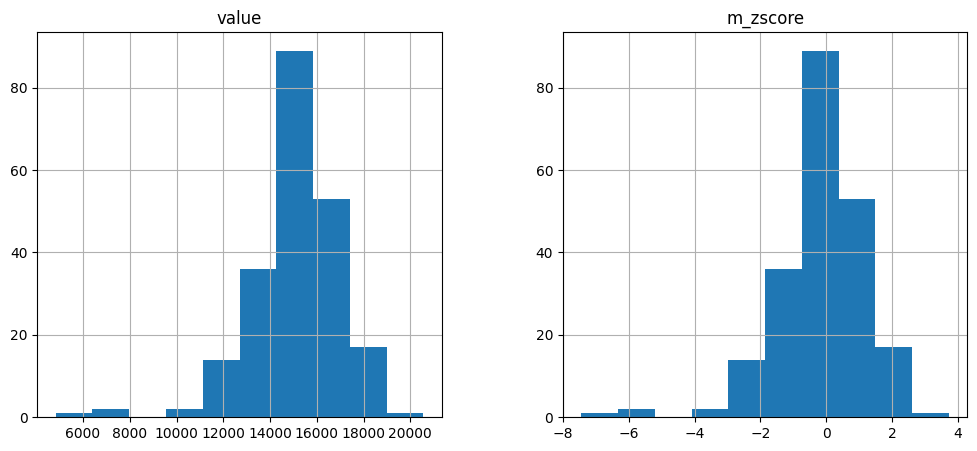

In [112]:
transformed.hist()

### Examining Identified Outliers

Now let's look at the specific data points identified as outliers by the modified Z-score method. This will show us the dates and passenger counts that exceeded our threshold:

In [113]:
print(outliers['value'])

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


### Visualizing Outliers in the Time Series

Let's visualize these outliers in the context of our original time series data. This helps us understand the pattern and magnitude of the anomalies:

The plot clearly shows where the outliers are located in our time series. We can observe that the modified Z-score method successfully identified major events like holidays and severe weather that caused significant deviations in taxi passenger counts.

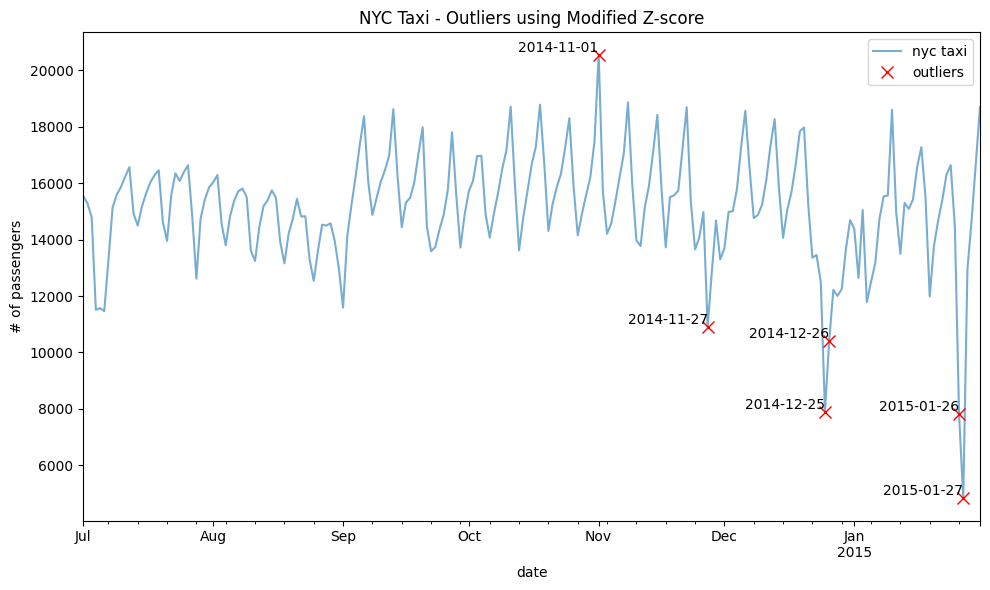

In [114]:
plot_outliers(outliers[['value']], tx, 'Outliers using Modified Z-score', labels=True)

### Visualizing Modified Z-Scores with Threshold Lines

We can also visualize the modified Z-scores directly, with horizontal lines indicating our threshold boundaries:

This plot shows:
1. All data points as black triangles, representing their modified Z-score values
2. Red dashed lines at +/- 3 standard deviations marking our threshold boundaries
3. Red circles highlighting the points identified as outliers (those beyond our thresholds)

Notice that one point is very close to the threshold line. This demonstrates the importance of carefully selecting threshold values and potentially investigating borderline cases.

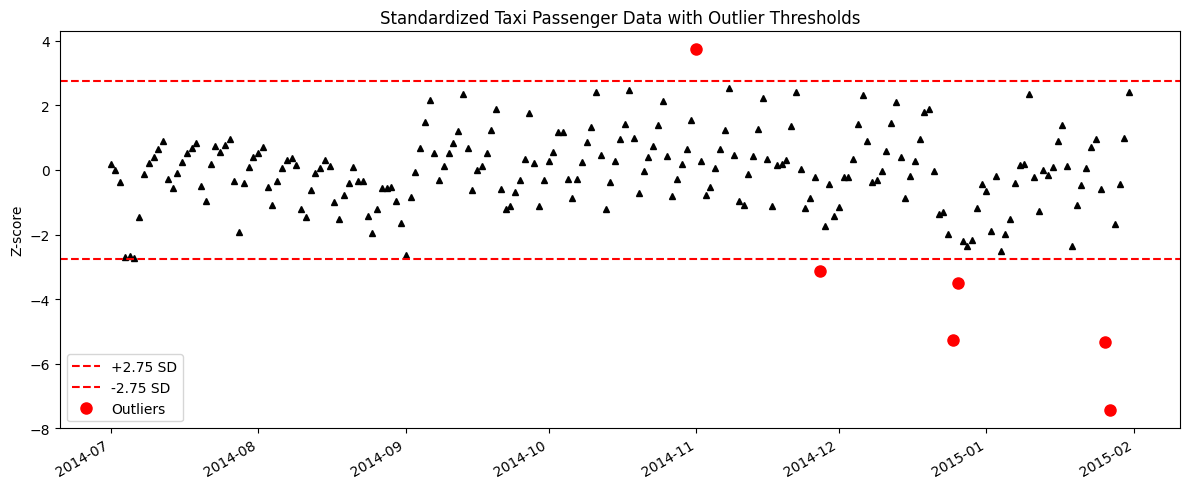

In [118]:
plot_zscore(transformed['m_zscore'], d=2.75)

## How it Works

The modified Z-score method improves upon the standard Z-score by using robust statistics—the median and Median Absolute Deviation (MAD)—which are less influenced by extreme values.

### Key advantages over standard Z-scores:

1. **Robustness to outliers:** Since the median and MAD are less affected by extreme values than the mean and standard deviation, the modified Z-score provides a more reliable measure when outliers are present.

2. **Works with non-normal distributions:** Unlike the standard Z-score, the modified Z-score does not assume that the underlying data follows a normal distribution, making it suitable for skewed or heavy-tailed data.

3. **Better detection performance:** In our example, the modified Z-score detected 6 outliers (compared to only 4 with the standard Z-score) and successfully identified more of the known anomalous dates.

4. **Consistency factor:** The constant 0.6745 (derived from the 75th percentile of the standard normal distribution) makes the modified Z-score comparable to the standard Z-score for normal distributions.

The modified Z-score is calculated as:

$$M_i = \frac{0.6745 \times (x_i - \tilde{x})}{MAD}$$

Where the MAD (Median Absolute Deviation) is:

$$MAD = median(|x_i - \tilde{x}|)$$

This approach minimizes the influence of outliers on both the measure of central tendency and the measure of dispersion, resulting in more reliable outlier detection, especially for real-world data.

## There's More: QQ-Plots for Normality Assessment

Another helpful tool for assessing normality and identifying potential outliers is the Quantile-Quantile plot (QQ-plot). A QQ-plot compares the quantiles of your data against the quantiles of a theoretical normal distribution, providing a visual assessment of how well your data follows a normal distribution.

If data points follow the reference line, it suggests the data follows a normal distribution. Deviations from the line indicate departures from normality, and points far from the line at the tails often represent outliers.

Let's create a QQ-plot using SciPy:

In [ ]:
import scipy
import matplotlib.pyplot as plt
scipy.stats.probplot(tx['value'], plot=plt);

### Alternative QQ-Plot Method

We can also create a QQ-plot using statsmodels, which provides a slightly different interface but produces the same visualization:

Both QQ-plots confirm what we discovered earlier - our taxi passenger data doesn't perfectly follow a normal distribution. We can observe noticeable deviations in both tails, particularly in the lower tail (theoretical quantiles below -2). 

This visualization reinforces why the modified Z-score method is more appropriate for this dataset than the standard Z-score method, as it doesn't rely on the assumption of normality.

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx['value'], line='s');

# Recipe 6: Detecting Outliers with Hampel Filter

The Hampel Filter extends the modified z-score concept into a rolling window implementation. Unlike the previous methods we've explored, the Hampel Filter considers the local behavior of the time series rather than treating the entire dataset as a single distribution. This makes it especially effective for data with changing baselines, seasonal patterns, or trends—all common characteristics of real-world time series data like our NYC taxi passenger counts.

The Hampel Filter operates as a moving window outlier detector, applying robust statistics to each local segment of your time series. For each data point:

1. A window of observations centered on the current point is selected
2. The median of values within this window is calculated
3. The Median Absolute Deviation (MAD) is computed as a robust measure of dispersion
4. The MAD is scaled by a factor (typically 1.4826) to make it comparable to standard deviation
5. Points falling outside a threshold of n_sigma times the scaled MAD are flagged as outliers

This approach is particularly valuable for time series data where normal behavior evolves over time, making global thresholds inappropriate.

In [119]:
!uv pip install sktime

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Resolved 13 packages in 824ms                                        
Installed 2 packages in 52ms                                
 + scikit-base==0.12.6
 + sktime==0.39.0


In [120]:
from sktime.transformations.series.outlier_detection import HampelFilter

In [123]:
def hampel_outlier_detection(df, window_length=10, n_sigma=3):
    """
    Detect outliers using sktime's HampelFilter implementation.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    window_length (int): Size of the sliding window
    n_sigma (float): Number of standard deviations to use as threshold
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with filtered values)
    """
    # Create a copy of the input data
    data = df.copy()
    
    # Initialize the HampelFilter
    hampel = HampelFilter(
        window_length=window_length,
        n_sigma=n_sigma,
        k=1.4826,  # Default scale factor for Gaussian distribution
        return_bool=False  # Return NaN for outliers
    )
    
    # Apply the filter - this will return a series with NaN values at outlier positions
    data['filtered'] = hampel.fit_transform(data['value'])
    
    # Identify outliers (where transformed values are NaN)
    outliers = data[data['filtered'].isna()]
    
    return outliers, data

We've created a `hampel_outlier_detection` function that wraps sktime's HampelFilter implementation to make it easier to use. This function accepts:

- `df`: The time series data with a 'value' column
- `window_length`: The size of the sliding window (controlling how much local context to consider)
- `n_sigma`: The threshold multiplier (controlling sensitivity to outliers)

The function returns both the detected outliers and the transformed data with outliers replaced by NaN values.

Two key parameters influence the Hampel Filter's behavior:

1. **window_length**: Controls the size of the sliding window. Larger windows detect outliers against broader patterns, while smaller windows are more sensitive to recent changes. For example:
   - For hourly data with daily patterns: Consider window_length = 24
   - For daily data with weekly patterns: Consider window_length = 7
   - For daily data with monthly patterns: Consider window_length = 21 or 30
   - For monthly data with yearly patterns: Consider window_length = 12

2. **n_sigma**: Determines how many scaled MADs a point must deviate to be considered an outlier:
   - Lower values (1.5-2.0): More sensitive, catches subtle anomalies but may have false positives
   - Middle values (2.5-3.0): Balanced approach
   - Higher values (>3.5): More conservative, fewer false positives but may miss subtle anomalies

Let's apply this to our NYC taxi data using a 21-day window to capture approximately monthly patterns:

In [124]:
# Usage example
tx = nyc_taxi.resample('D').mean()

In [125]:
window_length = 21  # Adjust based on your data's seasonality
n_sigma = 2.5 
outliers, transformed = hampel_outlier_detection(tx, window_length, n_sigma)

In [126]:
print(outliers['value'])

timestamp
2014-07-04    11511.770833
2014-07-05    11572.291667
2014-07-06    11464.270833
2014-07-28    12615.854167
2014-11-01    20553.500000
2014-12-06    18561.625000
2014-12-25     7902.125000
2015-01-10    18597.166667
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


Let's examine the outliers detected by the Hampel Filter:

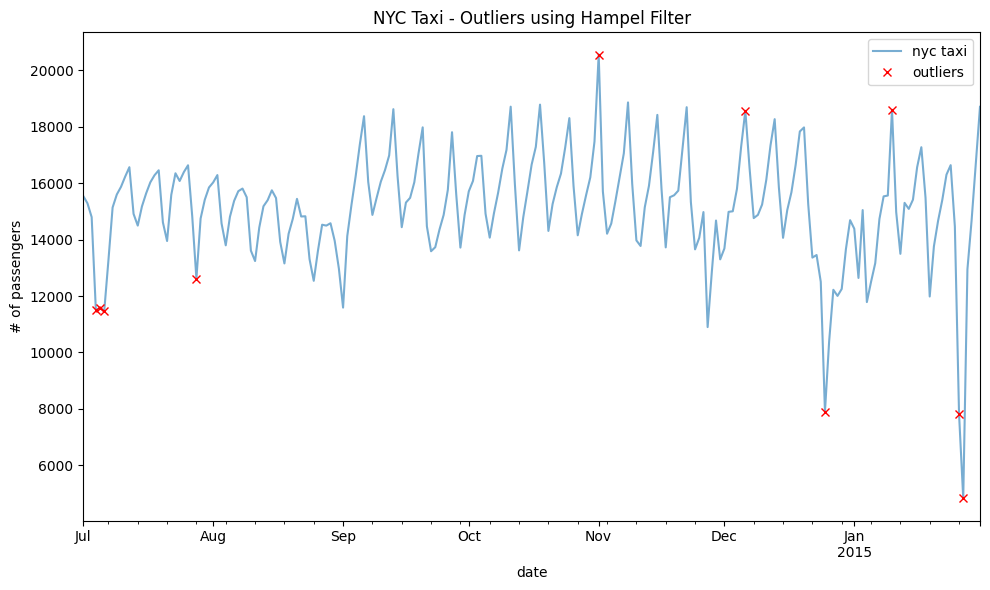

In [127]:
plot_outliers(outliers[['value']], tx, 'Outliers using Hampel Filter')

The Hampel Filter has identified several potential outliers in our taxi data. Notably, it has successfully detected three of our five known anomalous dates:
- November 1, 2014: NYC Marathon preparation
- December 25, 2014: Christmas Day 
- January 27, 2015: Blizzard

It also flagged January 26, 2015 (the day before the blizzard), showing that the impact started to appear before the actual weather event.

The dates in early July (July 4-6, 2014) likely correspond to Independence Day weekend, which naturally affects taxi usage patterns. These could be subtle anomalies or false positives, depending on your domain knowledge.

The number of outliers detected (10) suggests our current settings might be a bit lenient. To be more conservative, you could:
1. Use a larger window (e.g., 30 days) to incorporate more context
2. Increase the threshold (e.g., n_sigma=3.0) to be more selective about what counts as an outlier

The ideal parameters depend on your specific application needs and the balance between sensitivity (catching all true anomalies) and specificity (avoiding false positives).

<Axes: xlabel='timestamp'>

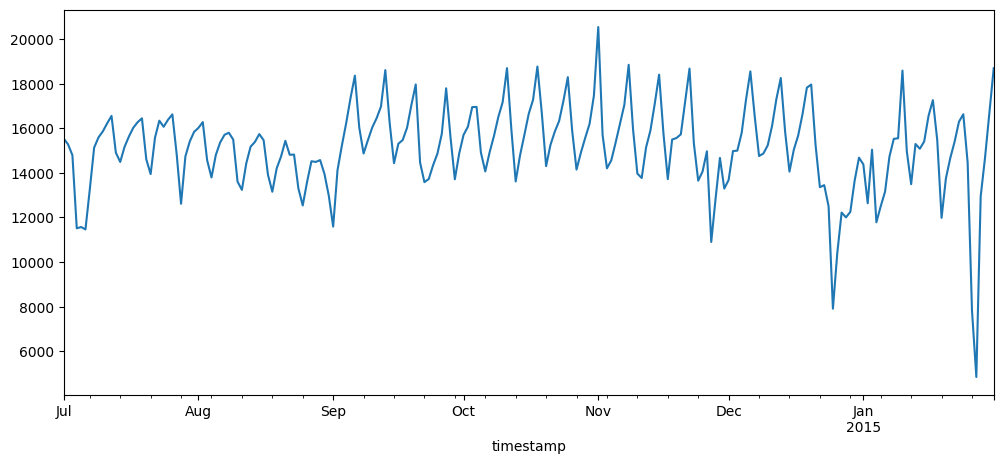

In [128]:
transformed['value'].plot()

### There is more

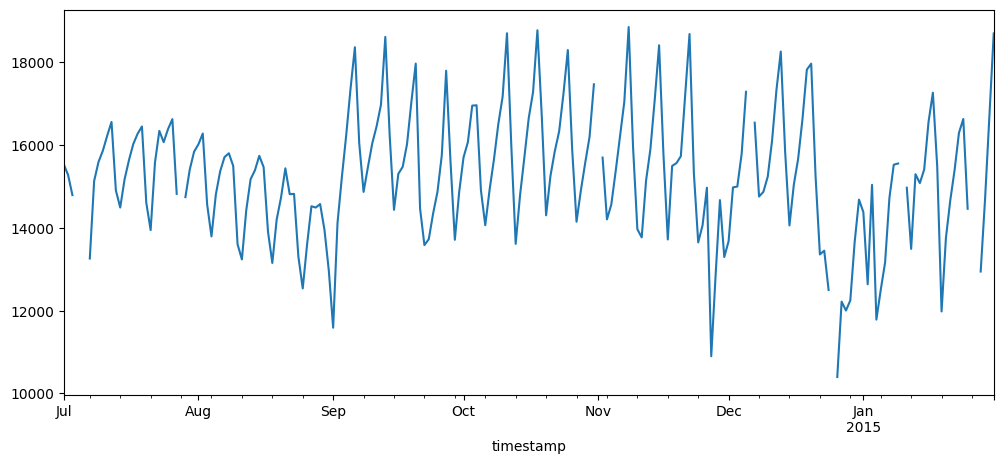

In [129]:
transformed['filtered'].plot();

In the HampelFilter implementation from sktime, outliers are replaced with NaN values by default, effectively filtering them out of the data without replacing them with alternative values. The plot above shows the filtered time series with gaps where outliers were detected.

To correct for these missing values (former outliers), we can use sktime's Imputer class which provides several methods for filling in gaps in time series data:

In [ ]:
from sktime.transformations.series.impute import Imputer

# Other options: "mean", "median", "nearest", etc.
imputer = Imputer(method="linear")  

# Fill in the missing values (former outliers)
y_corrected = imputer.fit_transform(transformed['filtered'])

In [ ]:
y_corrected.plot()
plt.title("Daily Average Taxi Passengers After Linear Imputation");

The linear imputation method fills in the gaps (outliers) with estimated values based on linear interpolation between the nearest valid data points. This creates a smoother time series that maintains the overall trend while removing extreme values.

The sktime Imputer class offers several other imputation methods including:
- 'mean': Fill with the mean of the series
- 'median': Fill with the median value
- 'nearest': Fill with the nearest valid value
- 'constant': Fill with a specified constant value
- 'backfill'/'pad': Fill with the next/previous valid value

For forecasting applications, proper handling of outliers is essential as they can significantly impact model performance.

## Detecting outliers with STRAY

The STRAY (Search TRace AnomalY) algorithm is another statistical method for anomaly and outlier detection. It's an extension of the HDoutliers algorithm, which is efficient at detecting clusters of outliers in multi-dimensional data. STRAY extends HDOutliers by using extreme value theory for calculating anomalous thresholds.

The algorithm is designed for detecting anomalies in data streams that exhibit **concept drift** - a phenomenon where the statistical properties of the target variable change over time in unforeseen ways. Examples include:

- Consumer behavior changing during economic shifts
- Traffic patterns evolving as new infrastructure is built
- Sensor readings drifting as equipment ages

The STRAY implementation involves several key components:

1. **Nearest Neighbor Computation**: The algorithm utilizes sklearn's NearestNeighbors to calculate distances between data points, leveraging a distance-based approach for outlier detection.
2. **Threshold Determination**: STRAY utilizes extreme value theory (EVT) to calculate thresholds for anomaly detection, identifying outliers that deviate significantly from expected behavior.
3. **Hyperparameters**: Key parameters include:
   - `alpha`: Outlier cutoff threshold (default is 0.01)
   - `k`: Number of neighbors considered (default is 10)
   - `knn_algorithm`: Method for computing nearest neighbors (default is 'brute')
   - `p`: Proportion of outlier candidates (default is 0.5)
   - `size_threshold`: Sample size for empirical threshold calculation (default is 50)
   - `outlier_tail`: Direction of the outlier tail (default is 'max')

Let's apply STRAY to our downsampled average NYC taxi passenger counts:

In [157]:
from sktime.detection.stray import STRAY

model = STRAY(k=7, alpha=0.05)
model.fit(tx['value'])
# True if anomalous, false otherwise
output = model.transform(tx['value'])

In [158]:
output.sum()

np.int64(5)

In [159]:
outliers = tx[output]
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [160]:
nyc_dates 

['2014-11-01', '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-27']

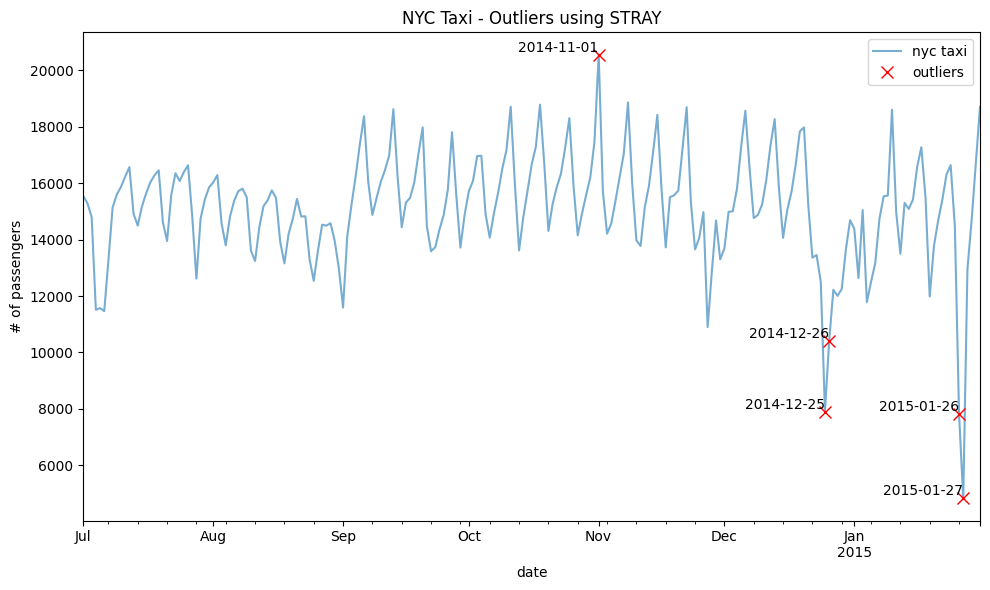

In [161]:
plot_outliers(outliers, tx, 'Outliers using STRAY', labels=True)

The STRAY algorithm detected five potential outliers, of which three are our known outliers. Interestingly, it also identified December 26, 2014 (the day after Christmas) and January 26, 2015 (the day before the blizzard), suggesting that these events had extended effects on taxi usage patterns.

This shows how different algorithms can detect different aspects of anomalies in the data. While point-based methods like z-score might focus on individual extreme values, STRAY can better capture contextual anomalies where points become unusual due to their relationship with surrounding data.

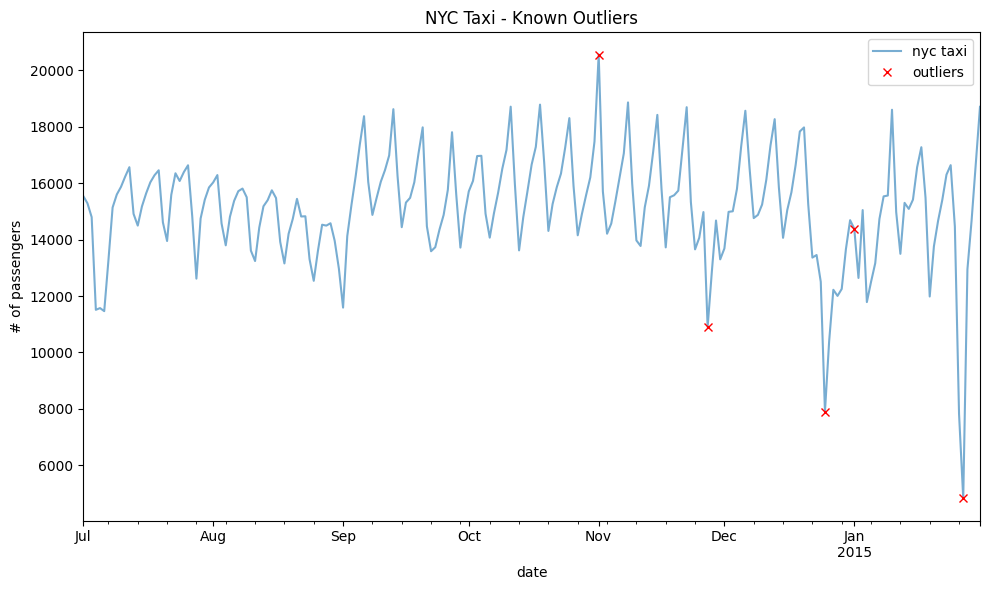

In [135]:
plot_outliers(known_outliers, tx, 'Known Outliers')

## Detecting outliers with Matrix Profile

Matrix Profile is a powerful technique for time series analysis that finds patterns and anomalies by comparing every possible subsequence of your data against all other subsequences. It's fundamentally different from the other outlier detection methods we've seen so far:

- **Traditional Methods** (z-score, Hampel Filter, IQR, STRAY): Focus on individual points and their statistical properties
- **Matrix Profile**: Analyzes subsequence similarity patterns within your time series

A subsequence in Matrix Profile is a continuous segment of fixed length extracted from your time series data—essentially a "window" that slides across your time series, capturing snapshots of your data's behavior over time.

### How Matrix Profile Works

Matrix Profile computes the Euclidean distance between each subsequence and its nearest non-trivial match elsewhere in the time series, creating a 'profile' of these minimum distances. This measures how similar or dissimilar each segment is to any other segment in the dataset.

For two subsequences A and B, each containing m points, the Euclidean distance is calculated as: 
$$d(A,B)=\sqrt{\sum_{i=0}^{m-1}(A_i-B_i)^2}$$

### Choosing the Subsequence Length

The choice of subsequence length (m) is crucial because it defines what constitutes a "pattern" in your data. For our average daily taxi data:

- **Length 1-2**: Detect unusual point transitions (close to point anomalies)
- **Length 7**: Detect unusual weekly patterns (e.g., weeks where the typical weekday/weekend pattern was disrupted)
- **Length 30**: Detect unusual monthly patterns (e.g., months with unusual seasonal transitions)
- **Length 365**: Detect unusual annual patterns

Let's apply Matrix Profile to our taxi data with a 30-day subsequence length to search for unusual monthly patterns:

In [162]:
from sktime.transformations.panel.matrix_profile import MatrixProfile

# Set the subsequence length (window size)
subsequence_length = 30

# Create the MatrixProfile transformer
mp_transformer = MatrixProfile(m=subsequence_length)
mp_result = mp_transformer.fit_transform(tx)

# The points with highest matrix profile values are the most anomalous
# You can set a threshold or take the top N highest values
threshold = np.percentile(mp_result, 95)  # Top 5% as anomalies
anomalies = mp_result > threshold

anomalies_series = anomalies.iloc[0]
anomaly_indices = np.where(anomalies_series)[0]

anomaly_timestamps = tx.index[anomaly_indices]

outliers = tx.loc[anomaly_timestamps]
print(outliers)

                   value
timestamp               
2014-08-09  15499.708333
2014-08-10  13607.979167
2014-08-11  13239.645833
2014-08-12  14426.500000
2014-08-13  15178.916667
2014-08-14  15394.395833
2014-11-27  10899.666667
2014-12-24  12502.000000
2014-12-25   7902.125000
2014-12-29  12250.479167


In [163]:
nyc_dates

['2014-11-01', '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-27']

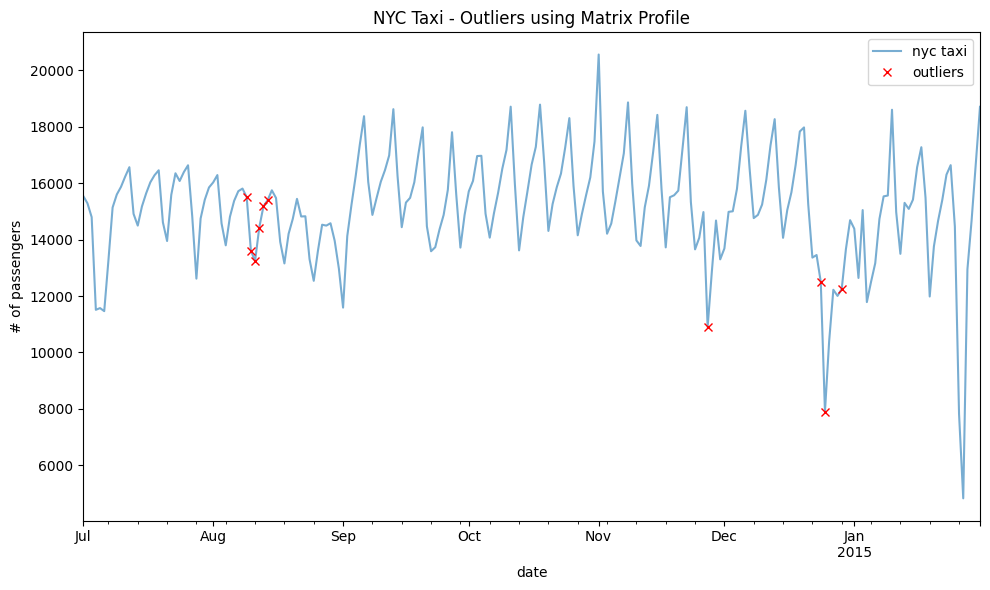

In [164]:
plot_outliers(outliers, tx, 'Outliers using Matrix Profile')

Matrix Profile successfully identified two of our known outliers: Thanksgiving (Nov 27) and Christmas (Dec 25). Interestingly, it also detected a series of days in August 2014 (8/9-8/14) as outliers, which none of the other methods flagged.

This demonstrates how Matrix Profile can uncover pattern anomalies that might be missed by point-based methods. The August period likely had a sequence of passenger counts that formed a pattern highly unusual compared to other 30-day patterns in the dataset. This highlights the complementary nature of different anomaly detection techniques:

- **Point-based methods** (z-score, Hampel Filter, IQR): Best for individual statistical outliers
- **Matrix Profile**: Better for finding anomalous periods or patterns—sequences of data that behave differently

### Summary of Outlier Detection Methods

We've explored several powerful techniques for detecting anomalies in time series data:

1. **Statistical methods** (z-score, modified z-score, Tukey's method): Simple but effective for point anomalies
2. **Hampel Filter**: Adapts to local context using sliding windows, good for data with trends
3. **STRAY**: Handles concept drift and focuses on distance-based anomalies
4. **Matrix Profile**: Excels at finding unusual patterns rather than just individual outlier points

The best approach often involves using multiple methods in combination, as each can reveal different types of anomalies in your data.